In [1]:
from C4I import benchmarks, clustering, evaluation, investment, risk_factors2, utils
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import corrcoef
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout,Input,Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

In [2]:
Metrics = {}

In [22]:
import matplotlib.pyplot as plt
import pandas as pd 

path = 'data'
base_line_data = 'Dataset'
X = pd.read_csv(f'{path}/close_price.csv')
X['Date'] = X['Date'].apply(lambda x: pd.to_datetime(x).date())

X.set_index('Date', inplace=True)
X.index = pd.to_datetime(X.index)
print(X.index)
print(X.head())
X.dropna(axis=1, how='any', inplace=True)
X = X.iloc[:, :100]
print(X.head())
test_start = '2022-12-21'
XD = utils.DailyPrice2DailyReturn(X)

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2023-08-17', '2023-08-18', '2023-08-21', '2023-08-22',
               '2023-08-23', '2023-08-24', '2023-08-25', '2023-08-28',
               '2023-08-29', '2023-08-30'],
              dtype='datetime64[ns]', name='Date', length=1928, freq=None)
                   MMM        AOS        ABT       ABBV       ABMD        ACN  \
Date                                                                            
2016-01-04  113.048523  33.202068  37.160885  41.186237  85.239998  89.974754   
2016-01-05  113.541328  33.016586  37.152229  41.014664  85.000000  90.443031   
2016-01-06  111.254501  32.362957  36.840607  41.021812  85.300003  90.266327   
2016-01-07  108.544174  30.781895  35.957676  40.900269  81.919998  87.615585   
2016-01-08  108.174561  29.686659  35.204590  39.

In [4]:
test_start_12fold = ['2022-09-01', 
                     '2022-10-01', 
                     '2022-11-01', 
                     '2022-12-01', 
                     '2023-01-01', 
                     '2023-02-01', 
                     '2023-03-01', 
                     '2023-04-01', 
                     '2023-05-01', 
                     '2023-06-01', 
                     '2023-07-01', 
                     '2023-08-01',
                     '2023-09-01']

In [5]:
# for different model, return the mse of each fold
def metrics_model_kfold(daily_model,data=XD,test_start_12fold = test_start_12fold,name=""):
    metrics = {}
    for i in range (12):
        print("fold: ", i)
        X_test = XD[ XD.index >= test_start_12fold[i]]
        X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
        X_each_fold = X[ X.index < test_start_12fold[i] ]
        
    
        if name not in  ["pca","vae"]:
            autoencoder_daily, encoder_daily = daily_model(X_each_fold,n_pcs=5)    
        else:
            autoencoder_daily = daily_model(X_each_fold,n_pcs=5)
            

        if name not in  ["pca","vae"]:
            res_daily = autoencoder_daily.predict(X_test_each_fold.values)
            
        else:
            if name == "pca":
                res_daily = autoencoder_daily.transform(X_test_each_fold)
                res_daily = autoencoder_daily.inverse_transform(res_daily)

                
            elif name=="vae":
                res_daily = autoencoder_daily.predict(X_test_each_fold.values)
                
        mse_daily = mean_squared_error(X_test_each_fold, res_daily)

        squared_errors = (X_test_each_fold - res_daily) ** 2    
        mse_per_day = squared_errors.mean(axis=1)
        metrics[i] = mse_per_day
        
    return metrics

In [6]:
# model 1; PCA
from sklearn.decomposition import PCA
def daily_model1_construct_and_train(data,n_pcs=5,SEED=1):
    pca_temp = PCA(n_components=n_pcs, random_state=SEED)
    pca_temp.fit(data.values)
    return pca_temp

Metrics["pca"] = metrics_model_kfold(daily_model1_construct_and_train,name="pca")

fold:  0
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
fold:  6
fold:  7
fold:  8
fold:  9
fold:  10
fold:  11


C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\xul14\anaconda3\lib\site-packages\sklearn\base.py:457: 

In [7]:
# model6: new
def daily_model6_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(32, activation='tanh', activity_regularizer=regularizers.l1(10**(-5)))(input_layer)
    #encoded_1 = Dropout(0.3)(encoded_1)
    encoded_2 = Dense(16, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(encoded_1)
    #encoded_2 = Dropout(0.3)(encoded_2)
    encoded_final = Dense(n_pcs, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(encoded_2)

    decoded_1 = Dense(16, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(encoded_final)
    #decoded_1 = Dropout(0.3)(decoded_1)
    decoded_2 = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(decoded_1)
    #decoded_2 = Dropout(0.3)(decoded_2)
    decoded_final = Dense(input_dim, activation='tanh', activity_regularizer=regularizers.l1(10**(-5)))(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=150, batch_size=32, shuffle=True, callbacks=[early_stopping], verbose=0)
    
    return autoencoder, encoder
Metrics["nnpca_small_size"] = metrics_model_kfold(daily_model6_construct_and_train)

fold:  0
1/1 [==============================] - 0s 88ms/step
fold:  1
1/1 [==============================] - 0s 62ms/step
fold:  2
1/1 [==============================] - 0s 63ms/step
fold:  3
1/1 [==============================] - 0s 61ms/step
fold:  4
1/1 [==============================] - 0s 62ms/step
fold:  5
1/1 [==============================] - 0s 62ms/step
fold:  6
1/1 [==============================] - 0s 63ms/step
fold:  7
1/1 [==============================] - 0s 62ms/step
fold:  8
1/1 [==============================] - 0s 62ms/step
fold:  9
1/1 [==============================] - 0s 63ms/step
fold:  10
1/1 [==============================] - 0s 62ms/step
fold:  11
1/1 [==============================] - 0s 61ms/step


In [8]:
# model 5:vae model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse


def model5_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    epochs = 50
    epsilon_std = 1

    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(64, activation='relu')(inputs)
    z_mean = Dense(n_pcs)(h)
    z_log_var = Dense(n_pcs)(h)

    # Sampling from the distribution
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(10,))([z_mean, z_log_var])

    # Decoder
    decoder_h = Dense(64, activation='relu')
    decoder_mean = Dense(input_dim, activation='linear')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # VAE model
    vae = Model(inputs, x_decoded_mean)

    # Loss
    reconstruction_loss = mse(inputs, x_decoded_mean)
    reconstruction_loss *= input_dim
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    return vae
Metrics["vae"] = metrics_model_kfold(model5_construct_and_train,name="vae")

fold:  0
1/1 [==============================] - 0s 56ms/step
fold:  1
1/1 [==============================] - 0s 52ms/step
fold:  2
1/1 [==============================] - 0s 57ms/step
fold:  3
1/1 [==============================] - 0s 43ms/step
fold:  4
1/1 [==============================] - 0s 54ms/step
fold:  5
1/1 [==============================] - 0s 54ms/step
fold:  6
1/1 [==============================] - 0s 54ms/step
fold:  7
1/1 [==============================] - 0s 56ms/step
fold:  8
1/1 [==============================] - 0s 54ms/step
fold:  9
1/1 [==============================] - 0s 54ms/step
fold:  10
1/1 [==============================] - 0s 53ms/step
fold:  11
1/1 [==============================] - 0s 58ms/step


In [9]:
# model3: without earlystoping
def daily_model3_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    # Define a deeper autoencoder architecture for daily data
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(64, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(input_layer)
    encoded_2 = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_1)
    encoded_final = Dense(n_pcs, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_2)

    # Symmetric decoder architecture
    decoded_1 = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_final)
    decoded_2 = Dense(64, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(decoded_1)
    decoded_final = Dense(input_dim, activation='linear', activity_regularizer=regularizers.l1(10**(-4)))(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    # Compile and train the autoencoder
    #early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='SGD', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=100, batch_size=16, shuffle=True,verbose=0)
    
    return autoencoder, encoder

Metrics["nnpca_without_early"] = metrics_model_kfold(daily_model3_construct_and_train)

fold:  0
1/1 [==============================] - 0s 63ms/step
fold:  1
1/1 [==============================] - 0s 62ms/step
fold:  2
1/1 [==============================] - 0s 62ms/step
fold:  3
1/1 [==============================] - 0s 66ms/step
fold:  4
1/1 [==============================] - 0s 63ms/step
fold:  5
1/1 [==============================] - 0s 62ms/step
fold:  6
1/1 [==============================] - 0s 63ms/step
fold:  7
1/1 [==============================] - 0s 62ms/step
fold:  8
1/1 [==============================] - 0s 69ms/step
fold:  9
1/1 [==============================] - 0s 65ms/step
fold:  10
1/1 [==============================] - 0s 62ms/step
fold:  11
1/1 [==============================] - 0s 63ms/step


In [10]:
def daily_model_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    # Define a deeper autoencoder architecture for daily data
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(64, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(input_layer)
    encoded_2 = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_1)
    encoded_final = Dense(n_pcs, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_2)

    # Symmetric decoder architecture
    decoded_1 = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(encoded_final)
    decoded_2 = Dense(64, activation='relu', activity_regularizer=regularizers.l1(10**(-4)))(decoded_1)
    decoded_final = Dense(input_dim, activation='tanh', activity_regularizer=regularizers.l1(10**(-4)))(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    # Compile and train the autoencoder
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    autoencoder.compile(optimizer='SGD', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=100, batch_size=16, shuffle=True,verbose=0)
    
    return autoencoder, encoder
Metrics["nnpca_original"] = metrics_model_kfold(daily_model_construct_and_train)

fold:  0
1/1 [==============================] - 0s 66ms/step
fold:  1
1/1 [==============================] - 0s 63ms/step
fold:  2
1/1 [==============================] - 0s 63ms/step
fold:  3
1/1 [==============================] - 0s 63ms/step
fold:  4
1/1 [==============================] - 0s 64ms/step
fold:  5
1/1 [==============================] - 0s 64ms/step
fold:  6
1/1 [==============================] - 0s 63ms/step
fold:  7
1/1 [==============================] - 0s 69ms/step
fold:  8
1/1 [==============================] - 0s 62ms/step
fold:  9
1/1 [==============================] - 0s 64ms/step
fold:  10
1/1 [==============================] - 0s 64ms/step
fold:  11
1/1 [==============================] - 0s 64ms/step


In [11]:
# model10: 
def daily_model10_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(128, activation='tanh', activity_regularizer=regularizers.l1(10**(-5)))(input_layer)
    encoded_1 = Dropout(0.3)(encoded_1)
    encoded_2 = Dense(64, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(encoded_1)
    encoded_2 = Dropout(0.3)(encoded_2)
    encoded_final = Dense(n_pcs, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(encoded_2)

    decoded_1 = Dense(64, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(encoded_final)
    decoded_1 = Dropout(0.3)(decoded_1)
    decoded_2 = Dense(128, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(decoded_1)
    decoded_2 = Dropout(0.3)(decoded_2)
    decoded_final = Dense(input_dim, activation='tanh', activity_regularizer=regularizers.l1(10**(-5)))(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=150, batch_size=32, shuffle=True, callbacks=[early_stopping], verbose=0)
    
    return autoencoder, encoder
Metrics["nnpca_big_size"] = metrics_model_kfold(daily_model10_construct_and_train)

fold:  0
1/1 [==============================] - 0s 69ms/step
fold:  1
1/1 [==============================] - 0s 64ms/step
fold:  2
1/1 [==============================] - 0s 64ms/step
fold:  3
1/1 [==============================] - 0s 63ms/step
fold:  4
1/1 [==============================] - 0s 66ms/step
fold:  5
1/1 [==============================] - 0s 65ms/step
fold:  6
1/1 [==============================] - 0s 68ms/step
fold:  7
1/1 [==============================] - 0s 66ms/step
fold:  8
1/1 [==============================] - 0s 65ms/step
fold:  9
1/1 [==============================] - 0s 66ms/step
fold:  10
1/1 [==============================] - 0s 65ms/step
fold:  11
1/1 [==============================] - 0s 67ms/step


In [12]:
# model11 
def daily_model11_construct_and_train(data,n_pcs=5):
    input_dim = data.shape[1]
    
    input_layer = Input(shape=(input_dim,))
    encoded_1 = Dense(1024, activation='tanh', activity_regularizer=regularizers.l1(10**(-5)))(input_layer)
    encoded_1 = Dropout(0.3)(encoded_1)
    encoded_2 = Dense(512, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(encoded_1)
    encoded_2 = Dropout(0.3)(encoded_2)
    encoded_final = Dense(n_pcs, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(encoded_2)

    decoded_1 = Dense(512, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(encoded_final)
    decoded_1 = Dropout(0.3)(decoded_1)
    decoded_2 = Dense(1024, activation='relu', activity_regularizer=regularizers.l1(10**(-5)))(decoded_1)
    decoded_2 = Dropout(0.3)(decoded_2)
    decoded_final = Dense(input_dim, activation='tanh', activity_regularizer=regularizers.l1(10**(-5)))(decoded_2)

    autoencoder = Model(input_layer, decoded_final)
    encoder = Model(input_layer, encoded_final)
    
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(data.values, data.values, epochs=150, batch_size=32, shuffle=True, callbacks=[early_stopping], verbose=0)
    
    return autoencoder, encoder
Metrics["nnpca_super_size"] = metrics_model_kfold(daily_model11_construct_and_train)

fold:  0
1/1 [==============================] - 0s 68ms/step
fold:  1
1/1 [==============================] - 0s 72ms/step
fold:  2
1/1 [==============================] - 0s 67ms/step
fold:  3
1/1 [==============================] - 0s 120ms/step
fold:  4
1/1 [==============================] - 0s 70ms/step
fold:  5
1/1 [==============================] - 0s 69ms/step
fold:  6
1/1 [==============================] - 0s 71ms/step
fold:  7
1/1 [==============================] - 0s 67ms/step
fold:  8
1/1 [==============================] - 1s 513ms/step
fold:  9
1/1 [==============================] - 0s 74ms/step
fold:  10
1/1 [==============================] - 0s 68ms/step
fold:  11
1/1 [==============================] - 0s 84ms/step


In [16]:
[i for i in Metrics]

['pca',
 'nnpca_small_size',
 'vae',
 'nnpca_without_early',
 'nnpca_original',
 'nnpca_big_size',
 'nnpca_super_size']

C:\Users\xul14\AppData\Local\Temp\ipykernel_19920\3346697033.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


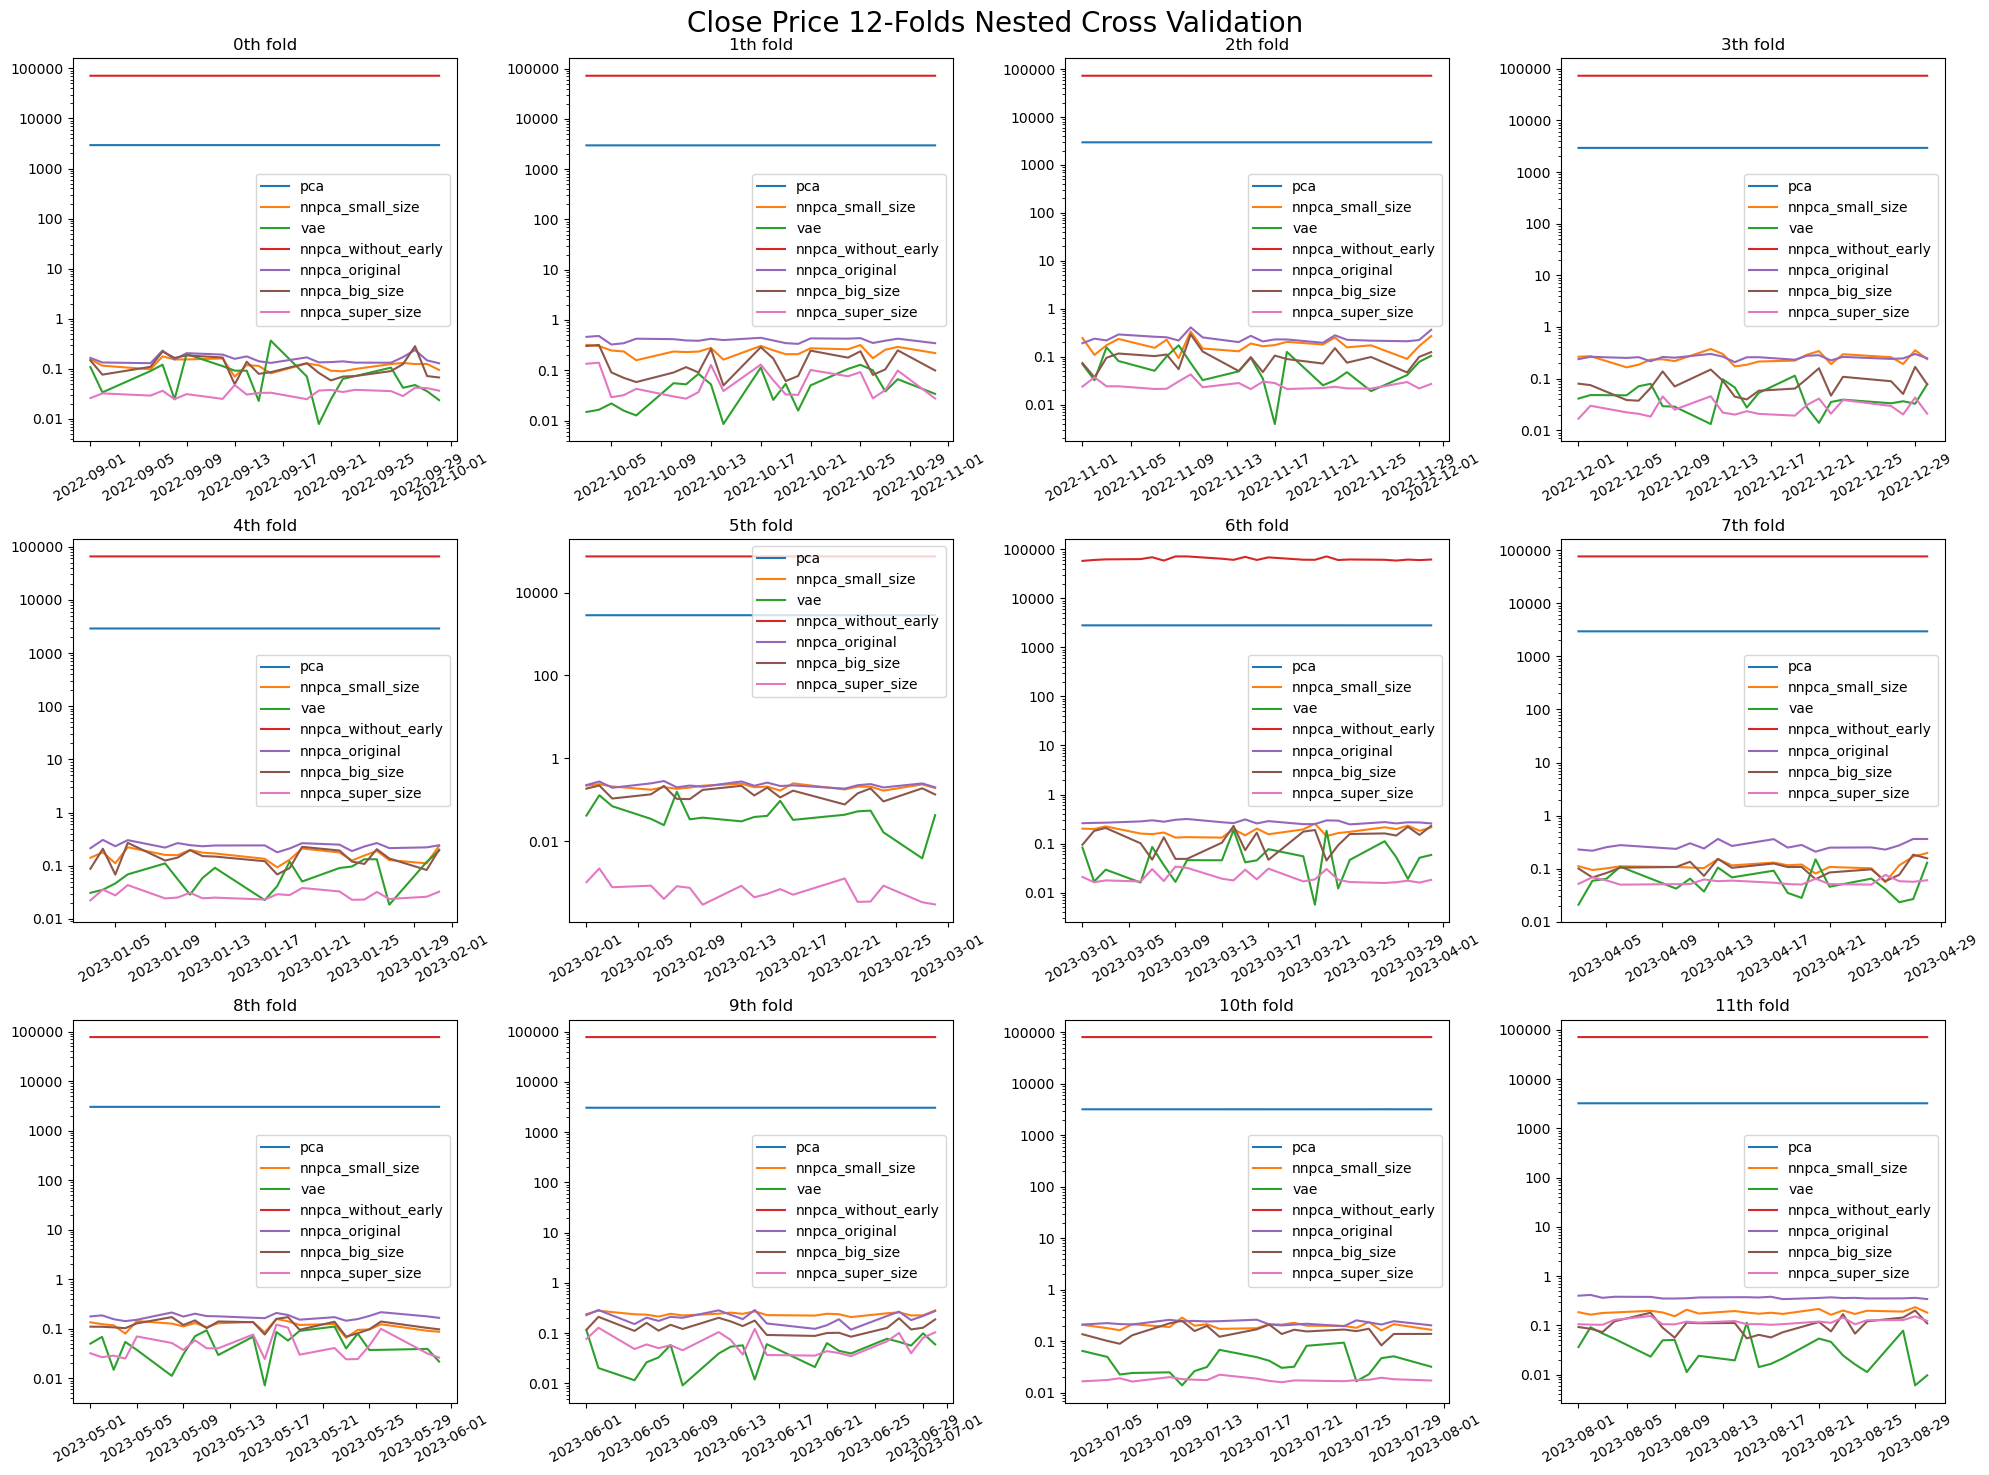

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

fig, axes = plt.subplots(3, 4, figsize=(20,15))
fig.suptitle("Close Price 12-Folds Nested Cross Validation",fontsize=20)
for i, ax in enumerate(axes.ravel()):
    for method, values in Metrics.items():
       # if method not in ["pca", 'nnpca_without_early']:
            ax.semilogy( values[i], label=method)
    ax.set_title(f"{i}th fold")
    ax.set_yscale("log") 

    ax.legend()
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
plt.tight_layout()
plt.legend()
plt.show()

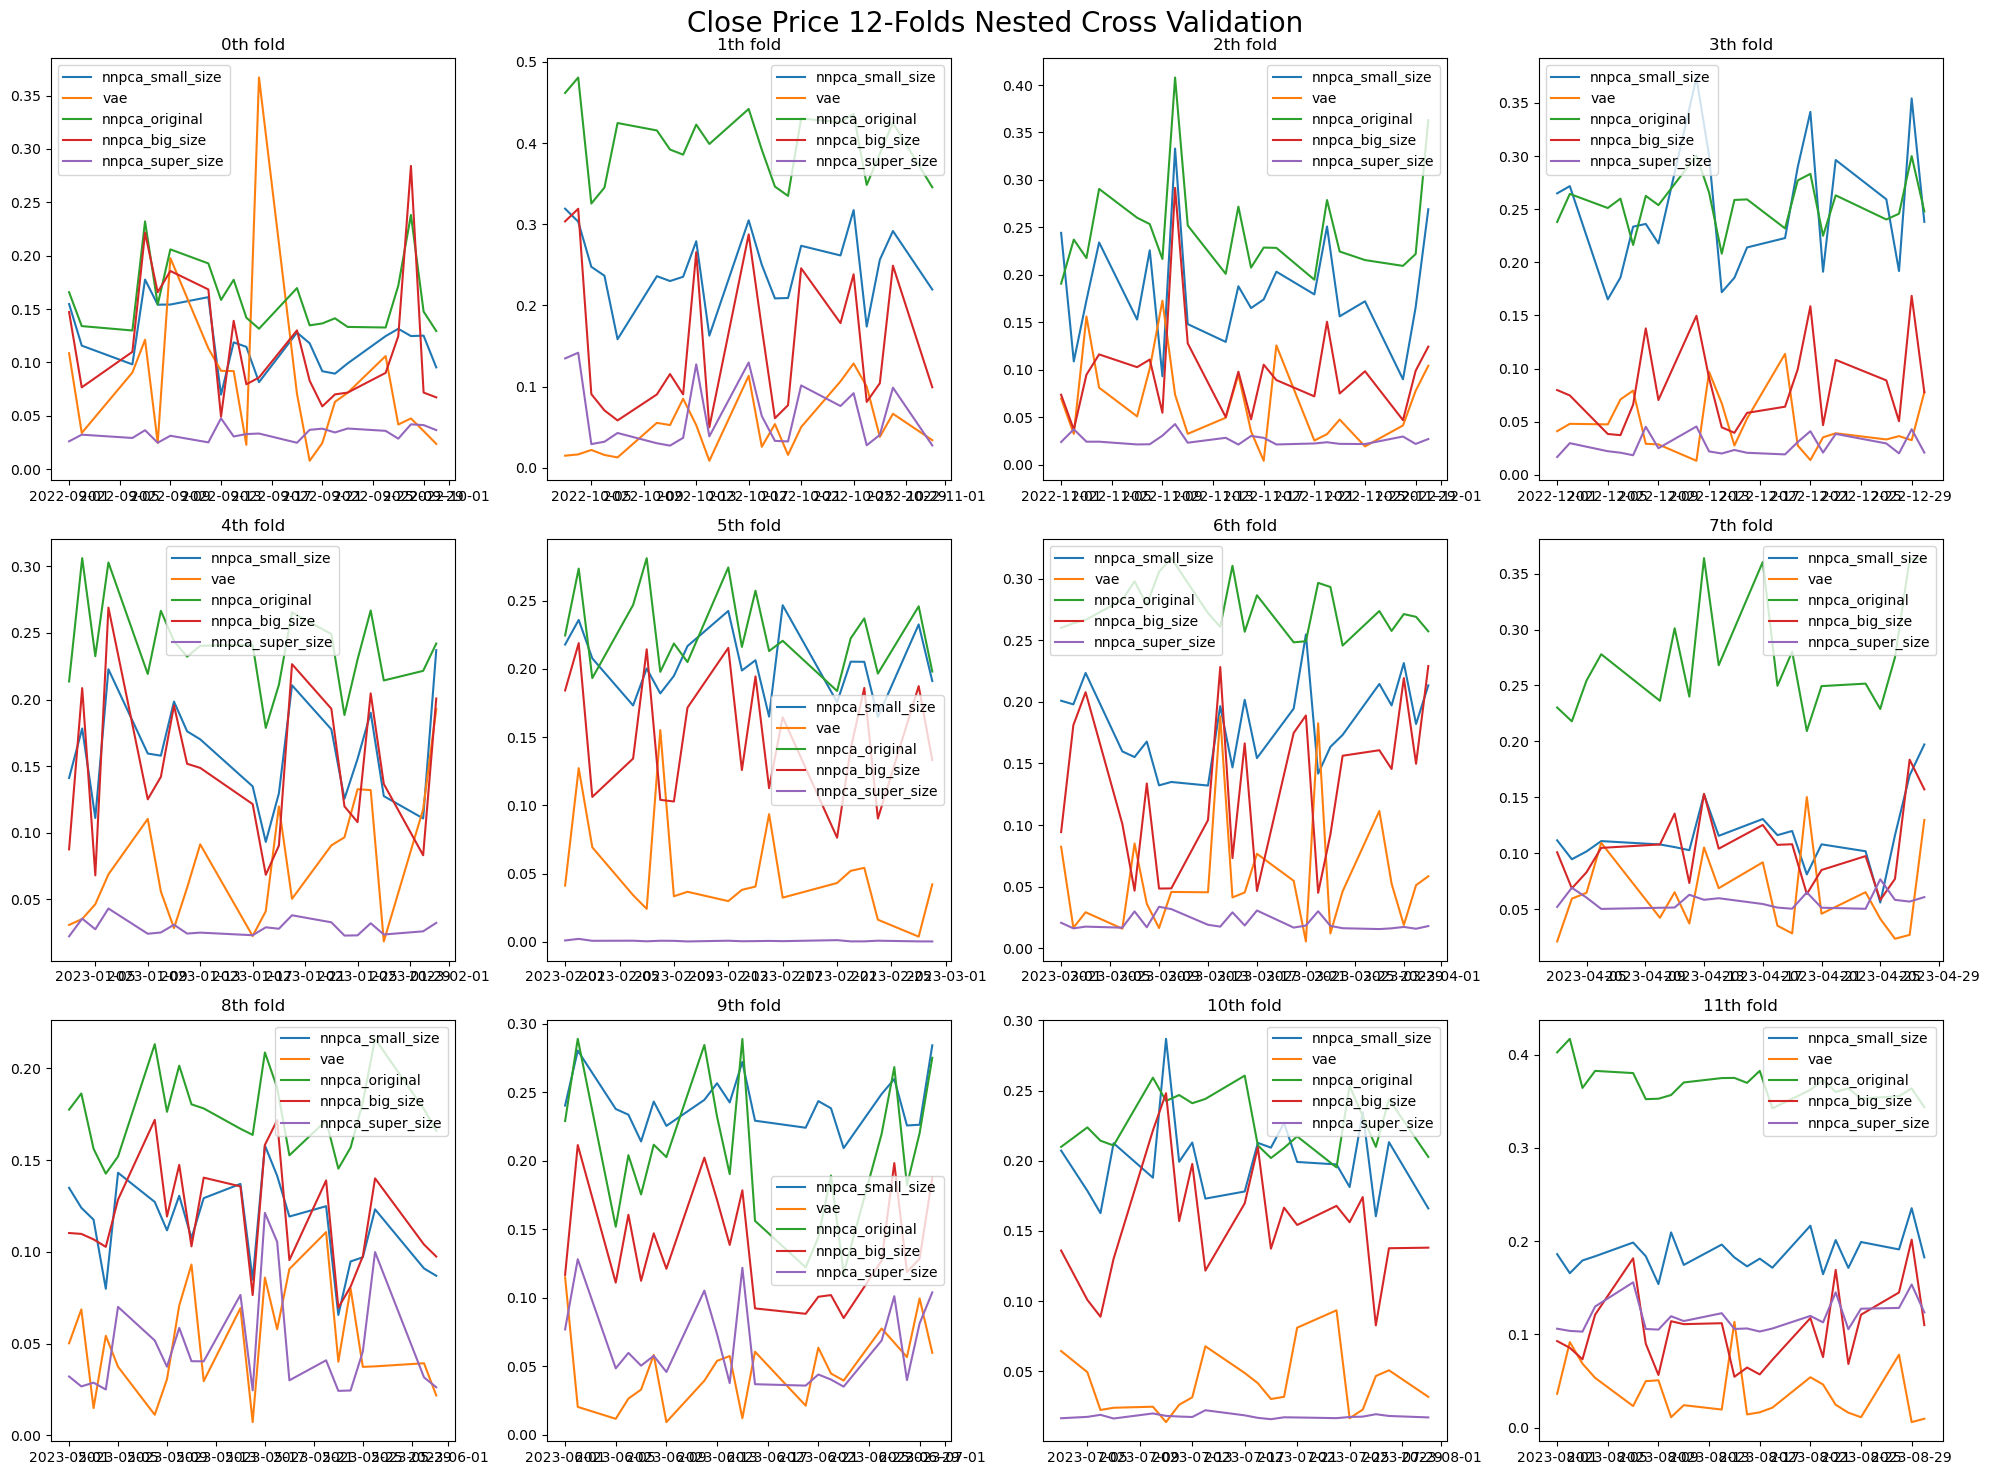

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle("Close Price 12-Folds Nested Cross Validation",fontsize=20)
for i, ax in enumerate(axes.ravel()):
    for method, values in Metrics.items():
        if method not in ["pca", 'nnpca_without_early']:
            #ax.semilogy(values[i], label=method)
            ax.plot(values[i], label=method)
    ax.set_title(f"{i}th fold")
    #ax.set_yscale("log") 

    ax.legend()
    #formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    #ax.yaxis.set_major_formatter(formatter)
    
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
plt.tight_layout()
plt.legend()
plt.show()

In [14]:
for key,val in Metrics.items():
    print(key,sum([val[i].mean() for i in range(12)])/12)

pca 2984.318940260577
nnpca_small_size 0.1835084579860092
vae 0.05661113180972879
nnpca_without_early 73026.72288300433
nnpca_original 0.25425961081897636
nnpca_big_size 0.12544504154287847
nnpca_super_size 0.042506541099384586
